In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           roc_curve, auc, classification_report)
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                   Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image
from google.colab import files
import random
import zipfile
import requests
import warnings
import math

In [23]:
warnings.filterwarnings('ignore')

tf.random.set_seed(42)
np.random.seed(42)

In [24]:
DATASET_URL = "https://github.com/Arfazrll/CA-Modul03-HandsOn/releases/download/TransferlearningNetv2/hyenacheetahclass.zip"

def download_dataset(url, output_file='hyenacheetahclass.zip'):
    if not os.path.exists(output_file):
        print("Downloading dataset...")
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(output_file, 'wb') as file:
            downloaded = 0
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
                    downloaded += len(chunk)
                    if total_size > 0:
                        progress = (downloaded / total_size) * 100
                        print(f"\rProgress: {progress:.1f}%", end='')
        print("\nDownload completed")
    else:
        print(f"Dataset {output_file} already exists")

def extract_dataset(zip_file='hyenacheetahclass.zip', extract_to='dataset'):
    if not os.path.exists(extract_to):
        print("Extracting dataset...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("Extraction completed")
    else:
        print(f"Dataset already extracted to {extract_to}")

download_dataset(DATASET_URL)
extract_dataset()

Dataset hyenacheetahclass.zip already exists
Dataset already extracted to dataset


In [25]:
DATASET_PATH = 'dataset'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VALIDATION_PATH = os.path.join(DATASET_PATH, 'validation')

In [26]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001

CLASS_NAMES = ['cheetah', 'hyena']
NUM_CLASSES = len(CLASS_NAMES)

print(f"Ukuran gambar: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Jumlah epoch: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Kelas: {CLASS_NAMES}")

Ukuran gambar: 224x224
Batch size: 32
Jumlah epoch: 50
Learning rate: 0.0001
Kelas: ['cheetah', 'hyena']


In [27]:
def preview_dataset():
    for split in ['train', 'validation']:
        split_path = os.path.join(DATASET_PATH, split)
        print(f"\n{split.upper()} SET:")

        total_files = 0
        for class_name in CLASS_NAMES:
            class_path = os.path.join(split_path, class_name)
            if os.path.exists(class_path):
                num_files = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"  {class_name}: {num_files} gambar")
                total_files += num_files
        print(f"  Total: {total_files} gambar")

preview_dataset()


TRAIN SET:
  cheetah: 800 gambar
  hyena: 800 gambar
  Total: 1600 gambar

VALIDATION SET:
  cheetah: 100 gambar
  hyena: 100 gambar
  Total: 200 gambar


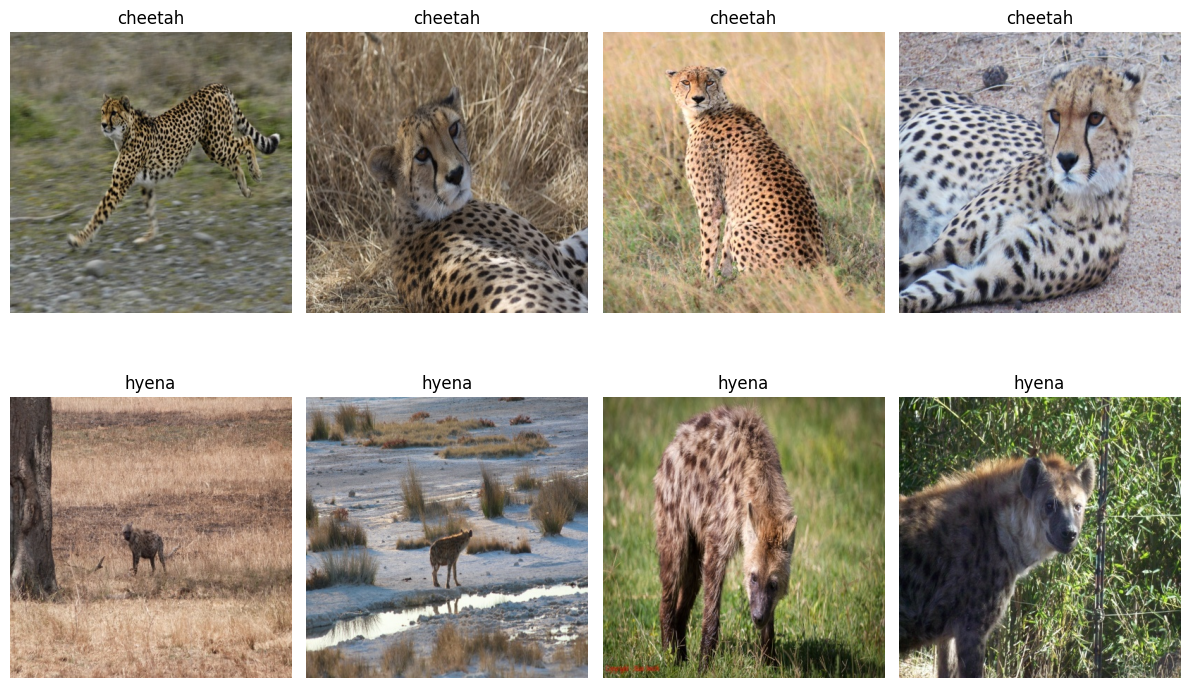

In [28]:
def sample_images():
    plt.figure(figsize=(12, 8))
    for i, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(TRAIN_PATH, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:4]

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(len(CLASS_NAMES), 4, i*4 + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

sample_images()

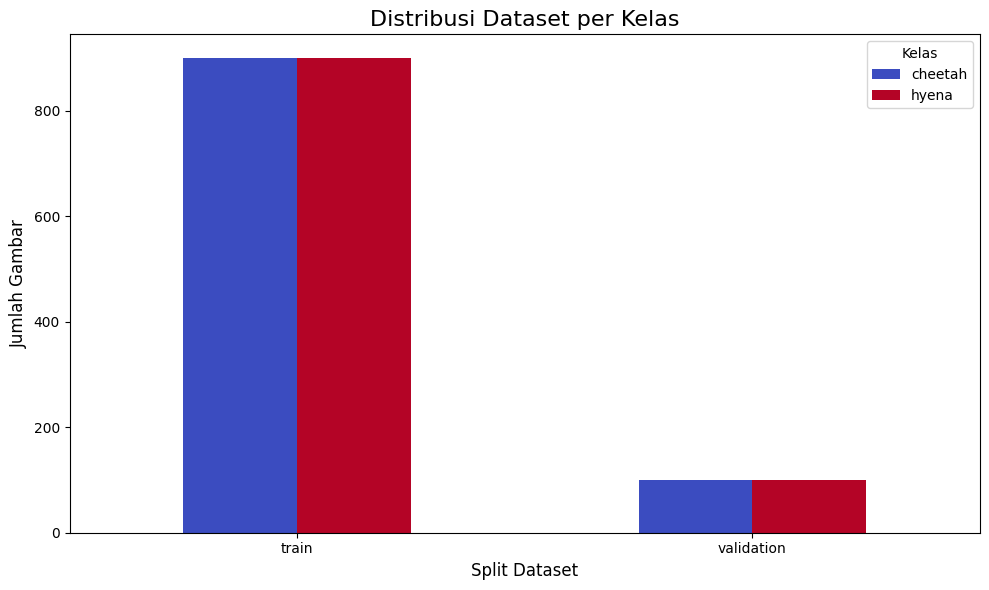

In [29]:
distribution_data = {
    'train': {'cheetah': 900, 'hyena': 900},
    'validation': {'cheetah': 100, 'hyena': 100}
}

df_distribution = pd.DataFrame(distribution_data)

plt.figure(figsize=(10, 6))
df_distribution.T.plot(kind='bar', colormap='coolwarm', ax=plt.gca())
plt.title('Distribusi Dataset per Kelas', fontsize=16)
plt.xlabel('Split Dataset', fontsize=12)
plt.ylabel('Jumlah Gambar', fontsize=12)
plt.legend(title='Kelas')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

In [30]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [31]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True, seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [32]:
print(f"Data training: {train_generator.samples} gambar")
print(f"Data validation: {validation_generator.samples} gambar")
print(f"Class indices: {train_generator.class_indices}")

Data training: 1600 gambar
Data validation: 200 gambar
Class indices: {'cheetah': 0, 'hyena': 1}


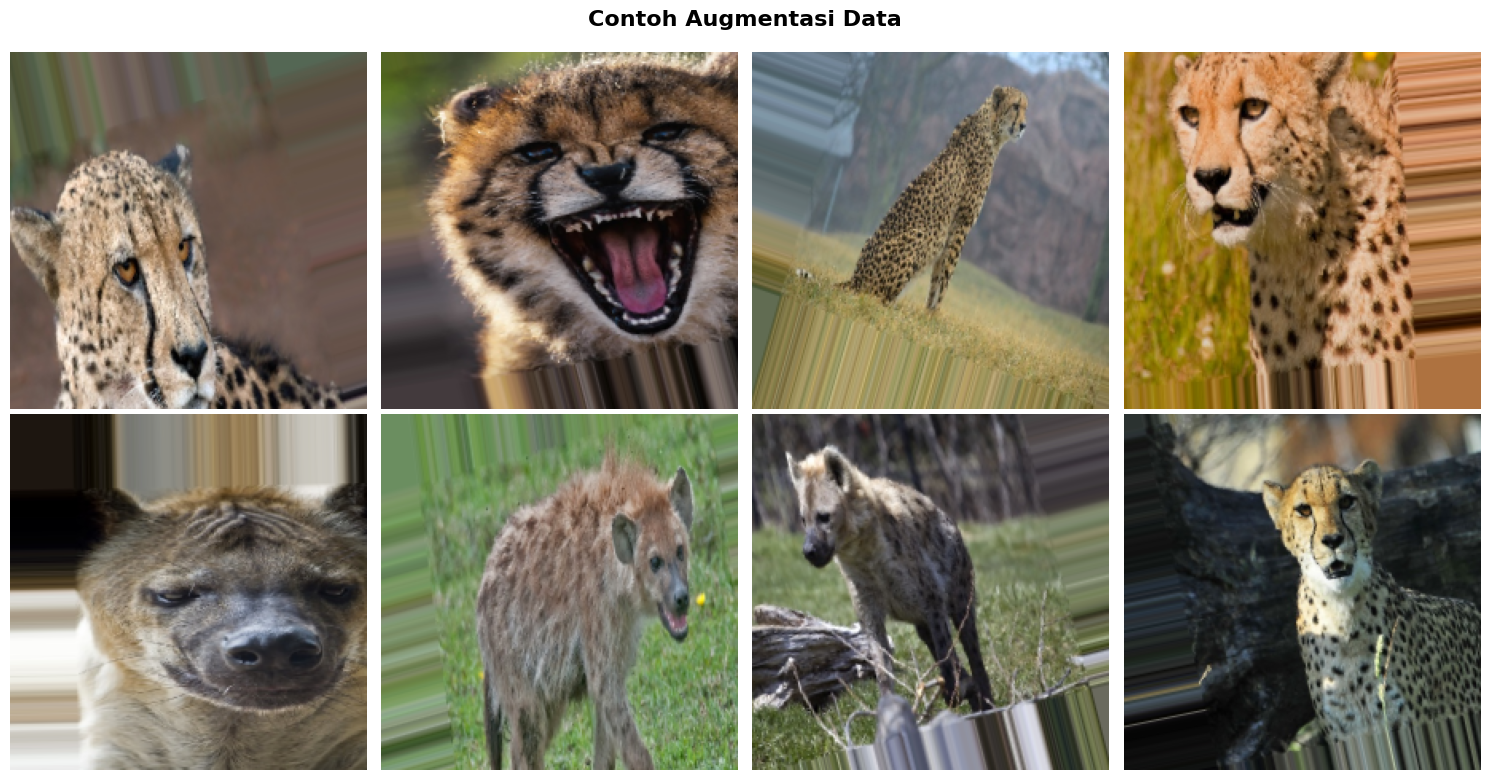

In [33]:
def augmented_images():
    sample_batch = next(train_generator)
    sample_images = sample_batch[0][:8]

    plt.figure(figsize=(15, 8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        img = sample_images[i]
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle('Contoh Augmentasi Data', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

augmented_images()

In [34]:
def model_cnn():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [35]:
model = model_cnn()
model.compile(
    optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=0.004),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
model_cnn = model_cnn()
model_cnn.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_transfer_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 720ms/step - accuracy: 0.6005 - loss: 0.7124 - val_accuracy: 0.9350 - val_loss: 0.3462 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.8857 - loss: 0.3326 - val_accuracy: 0.9900 - val_loss: 0.1937 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 422ms/step - accuracy: 0.9511 - loss: 0.2055 - val_accuracy: 0.9950 - val_loss: 0.1285 - learning_rate: 1.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9728 - loss: 0.1471 - val_accuracy: 0.9950 - val_loss: 0.0977 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.9736 - loss: 0.1141 - val_accuracy: 0.9950 - val_loss: 0.0794 - learning_rate: 1.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 417ms/step - accuracy: 0.9876 - loss: 0.0814 - val_accuracy: 0.9950 - val_loss: 0.0687 - learning_rate: 1.0000e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - acc

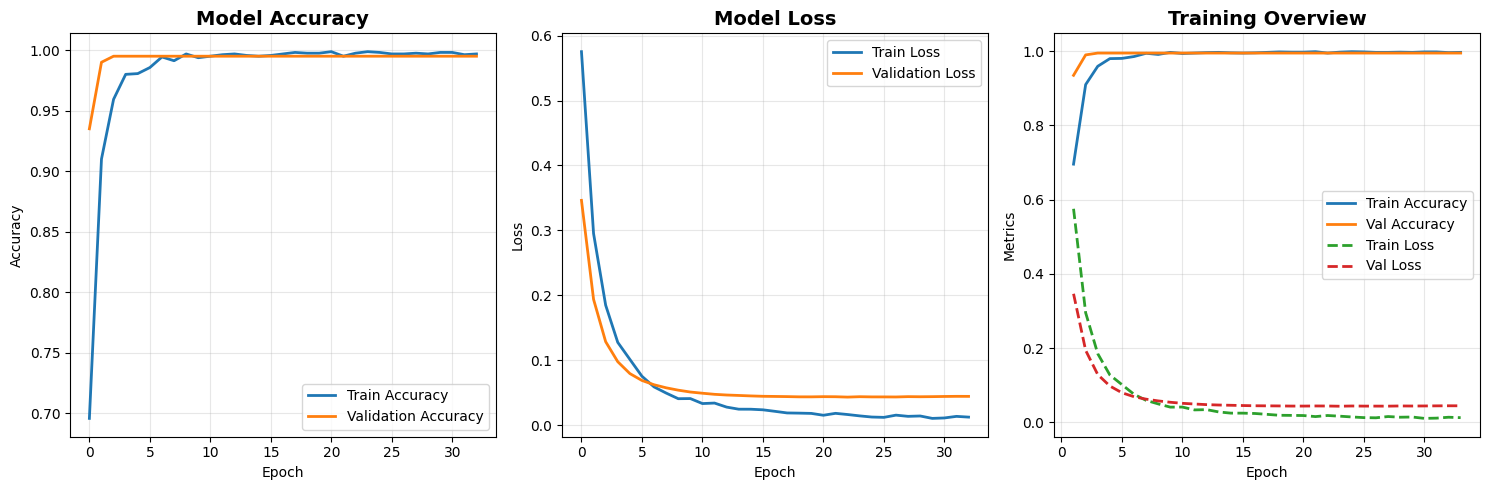

In [39]:
def plot_training_history():

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss', linewidth=2, linestyle='--')
    plt.plot(epochs_range, history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--')
    plt.title('Training Overview', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history()

In [40]:
best_model = load_model('best_transfer_model.keras')

true_classes = validation_generator.classes
steps = len(validation_generator)
predictions = best_model.predict(validation_generator, steps=steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES))

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 796ms/step

Classification Report:
              precision    recall  f1-score   support

     cheetah       1.00      0.99      0.99       100
       hyena       0.99      1.00      1.00       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200


Accuracy: 0.9950
Precision: 0.9950
Recall: 0.9950
F1-Score: 0.9950


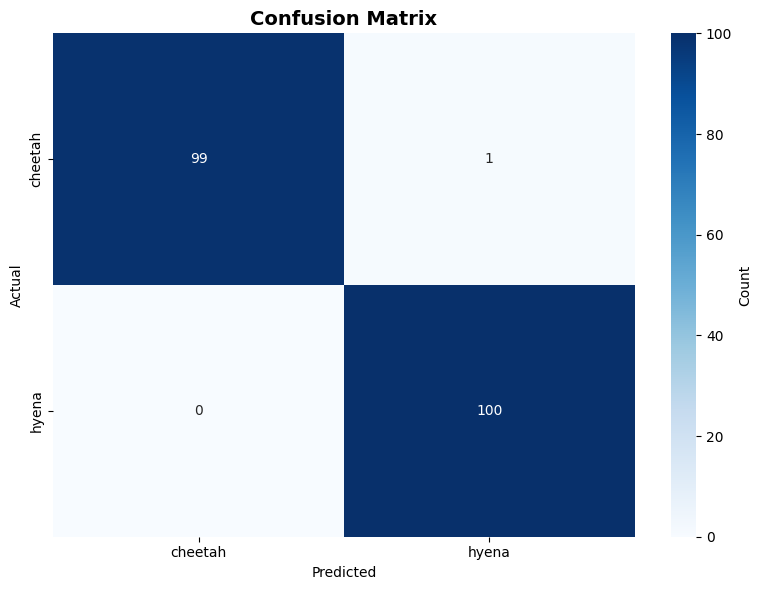

In [41]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

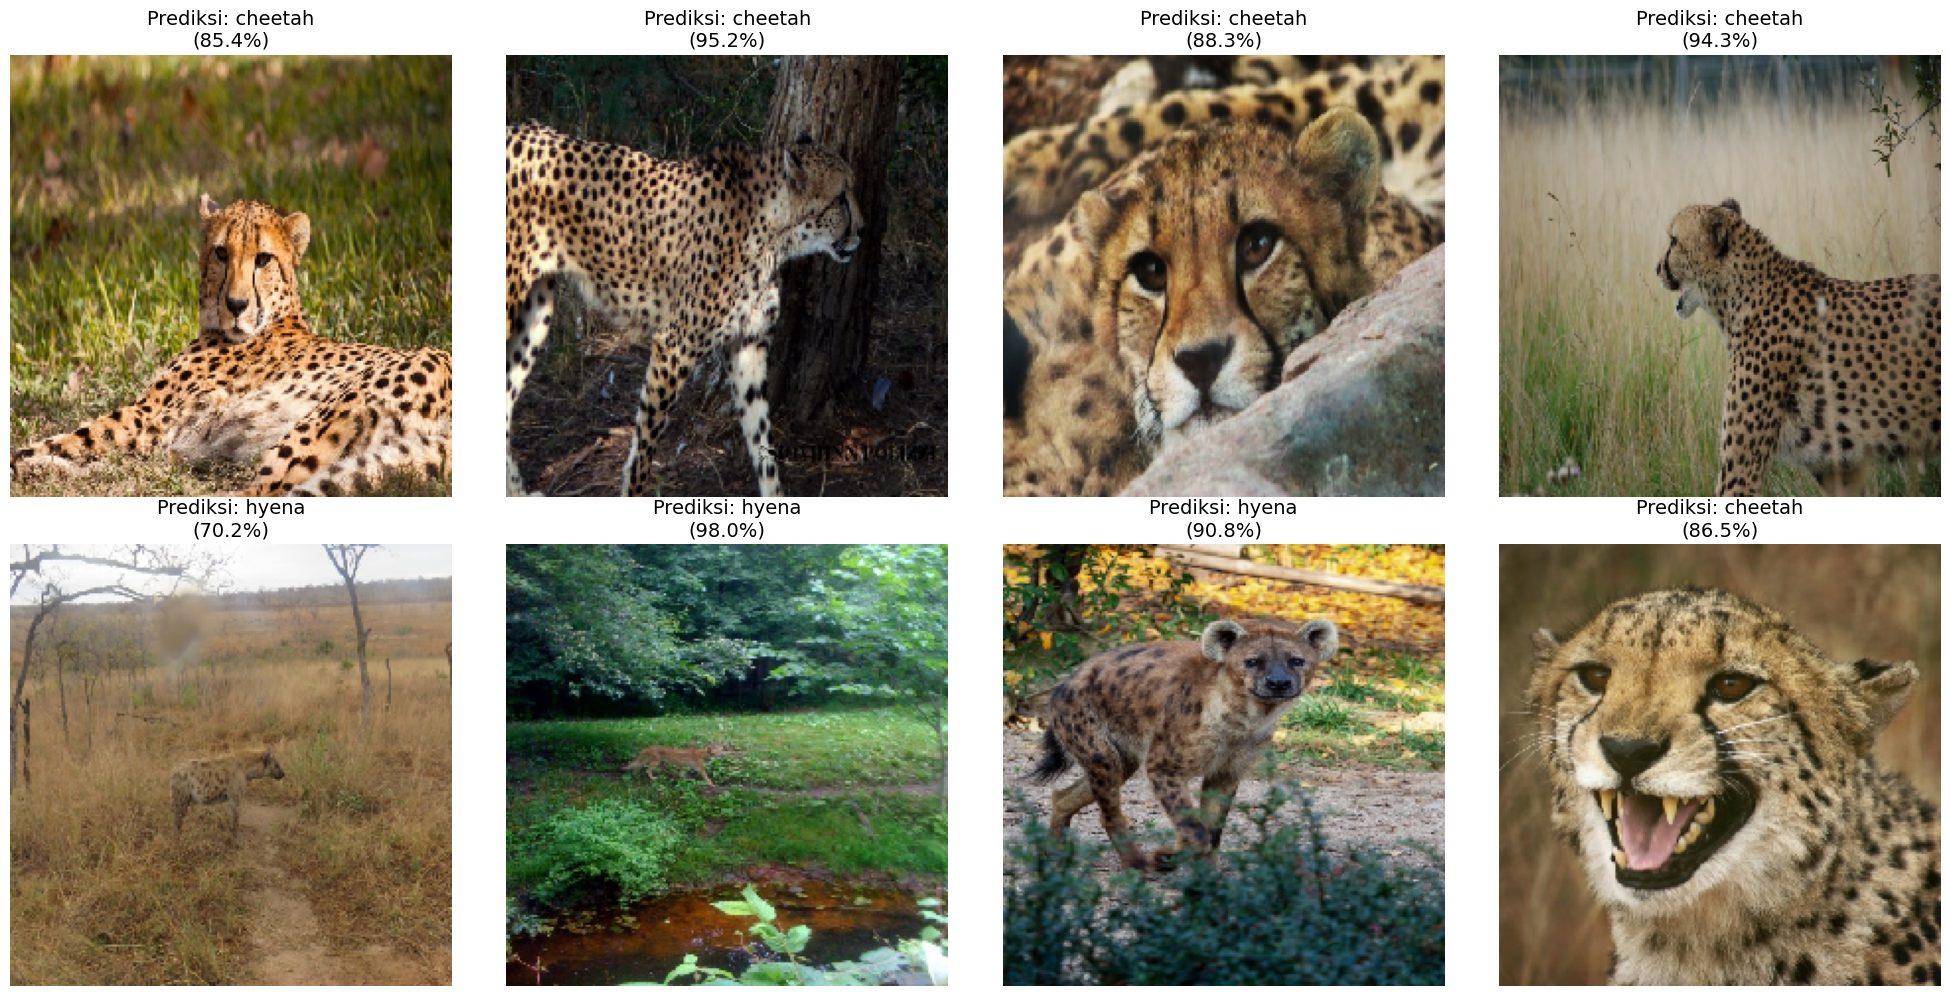

In [43]:
MODEL_PATH = 'best_transfer_model.keras'
NUM_SAMPLES = 8

all_images = []
for class_name in CLASS_NAMES:
    class_path = os.path.join(VALIDATION_PATH, class_name)
    if os.path.exists(class_path):
        all_images.extend([os.path.join(class_path, f) for f in os.listdir(class_path)])

sample_paths = random.sample(all_images, min(NUM_SAMPLES, len(all_images)))
model = load_model(MODEL_PATH)

plt.figure(figsize=(20, 10))

for i, img_path in enumerate(sample_paths):
    plt.subplot(2, 4, i + 1)

    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))

    prediction = model.predict(img_preprocessed, verbose=0)
    plt.imshow(img)
    confidence = np.max(prediction)
    predicted_class = CLASS_NAMES[np.argmax(prediction)]
    plt.title(f"Prediksi: {predicted_class}\n({confidence:.1%})", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

Saving hyena_027_val_resized.jpg to hyena_027_val_resized.jpg
Nama file: hyena_027_val_resized.jpg


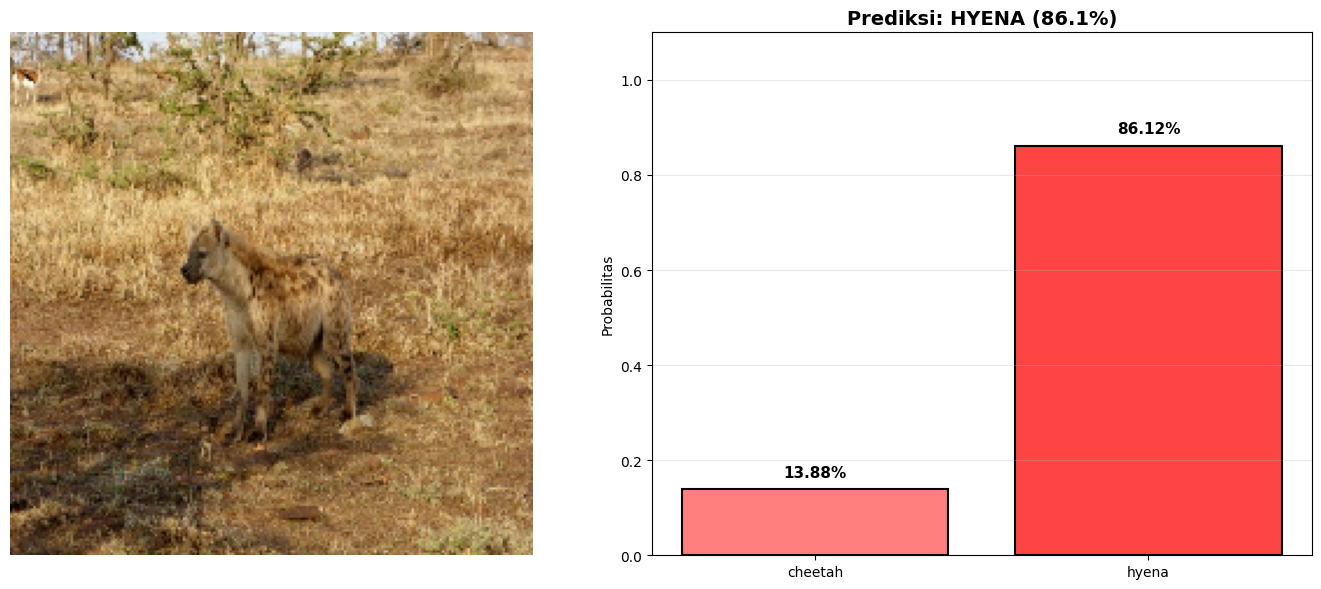


Gambar tersebut adalah: hyena


In [46]:
uploaded = files.upload()

for fn in uploaded.keys():
    print('Nama file:', fn)
    path = fn

    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))

    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))

    predictions = model.predict(img_preprocessed, verbose=0)
    class_indices = train_generator.class_indices
    class_indices = dict((v, k) for k, v in class_indices.items())
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_indices[predicted_class_index]
    confidence = np.max(predictions)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    colors = ['#ff7f7f' if i != predicted_class_index else '#ff4444'
              for i in range(len(CLASS_NAMES))]

    bars = plt.bar(CLASS_NAMES, predictions[0], color=colors, edgecolor='black', linewidth=1.5)
    plt.title(f'Prediksi: {predicted_class.upper()} ({confidence:.1%})', fontsize=14, fontweight='bold')
    plt.ylabel('Probabilitas')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)

    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h + 0.02, f'{h:.2%}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print(f'\nGambar tersebut adalah: {predicted_class}')
